# STOCK MARKET ANALYSIS
*By Alex Pattarini, Matt Carswell, Jude Moukarzel*

**Abstract**

Efficient data management is paramount in the realm of stock market analysis, where timely and accurate information is crucial for informed decision-making. The traditional manual approach to retrieving and processing daily stock data is fraught with inefficiencies, leading to errors and delays in financial analysis and trading strategies. This project addresses these challenges by proposing the implementation of an Extract, Transform, Load (ETL) pipeline tailored for stock market data management. 

The proposed ETL pipeline aims to streamline the data workflow by automating the extraction, transformation, and loading processes. Leveraging Polygon.io, the pipeline extracts daily stock data of top companies across major industries as well as market indices, including open price, close price, high, low, and transaction volume. Pydantic is employed for data schema validation during the extraction phase, ensuring data accuracy and completeness from the outset and mitigating potential errors downstream.  

In the transformation phase, the extracted data is structured for analysis and new features are engineered to facilitate deeper insights into the stock market trends and patterns. Subsequently, in the loading phase, the transformed data is stored and loaded into a structured JSON database, enhancing accessibility and facilitating seamless analysis. Data integrity and schema adherence are rigorously maintained during loading, with Prefect employed for error management and performance tracking. Prefect also facilitates comprehensive oversight of the ETL process, ensuring efficient error handling and performance optimization.  

By implementing this ETL pipeline, the inefficiencies inherent in manual data management practices within stock market analysis are effectively mitigated. Timely and accurate data processing is ensured, bolstering the reliability of financial analysis and trading strategies. Moreover, improved oversight and error handling mechanisms enhance the robustness of the data management framework, instilling confidence in decision-making processes.  

In conclusion, the proposed ETL pipeline offers a systematic approach to address the challenges associated with data management in stock market analysis. By automating key processes and leveraging advanced validation and tracking mechanisms, the pipeline offers a new era of efficiency and reliability in financial data processing.  

**Problem Outline**  
Each member of our group is a self-identified retail investor. We each have a portfolio of individual equities, mutual funds, ETFs, and a wide variety of other assets (we won't go into crypto) that we each actively manage as a great side hobby. While we enjoy managing our portfolios, we are all very busy data science students that also work jobs. While we could not manually sift through Yahoo Finance or get a paid market report to explain how the market and individual equities performed over the day, doing such is not ideal for the following reasons:

*   **Inefficiency in Data Access and Processing:** Manually retrieving and processing daily stock data is time-consuming and prone to errors. This inefficiency affects the timeliness and reliability of financial analysis and trading strategies.
*   **Difficulty in Tracking Progress and Ensuring Data Integrity**: Without a streamlined process, tracking the status of data retrieval and transformations across multiple stocks and markets is challenging. Ensuring the integrity and accuracy of financial data is crucial for making informed trading decisions.

We want to use our data science backgrounds to help us work around these problems of inefficiency and difficulty, creating some kind of automated way to get our own, customized market/stock report for the previous business day that we can peruse while we enjoy our morning coffees before the market opens for the day.

**Proposed Solution: Implementation of an ETL Pipeline**  
An ETL (Extract, Transform, Load) pipeline can address these challenges by automating the data workflow, ensuring data integrity, and improving data accessibility and tracking.

**Step 1: Extract**  
Retrieve daily stock data of the top companies within each major indistry as well as market indices such as open price, close price, high, low, and number of transactions using Polygon.io.  
Pydantic is used at this stage to validate the data schema as soon as data is extracted, ensuring the data types and required fields are correct and complete. This prevents errors early in the pipeline.  

**Step 2: Transform**  
Structure the data for analysis, creating a dataframe with all relevant values as well as engineering any new features needed for additional insights.

**Step 3: Load**  
Store and load the transformed and validated data in a structured JSON database for easy access and analysis. 
 
Data integrity and schema adherence are maintained during the loading phase, with logs and errors managed through Prefect, which also tracks the ETL process for performance and error handling.    

By leveraging this ETL pipeline, we can address the inefficiencies related to data management in stock market analysis, ensuring timely and accurate data processing with improved oversight and error handling.  

**Setting Up Prefect**

In [1]:
from google.colab import userdata
my_api_key = userdata.get('PREFECT_API_KEY')

%%capture
!pip install prefect
!prefect cloud login -k "$my_api_key" -w "jude-m385/default"

**Setting Up Polygon**

In [ ]:
!pip install -U polygon-api-client

from polygon import RESTClient
client = RESTClient(api_key="T0QpOfpp3phUHlnzbXCbzP2r0Z6Hvsj2")

## Individual Stocks

**Creating a List of Stock Tickers**

In [7]:
import pandas as pd
data = {
    'Ticker': [
        "AAPL", "MSFT", "GOOG", "META", "INTC", "NVDA", "AMD", "ORCL", "IBM", "QCOM",
        "JNJ", "PFE", "UNH", "MRK", "ABT", "ABBV", "AMGN", "TMO", "GILD", "BMY",
        "JPM", "BAC", "WFC", "C", "GS", "MS", "AXP", "BLK", "TFC", "SPGI",
        "XOM", "CVX", "COP", "SLB", "EOG", "PXD", "PSX", "VLO", "KMI", "WMB",
        "PG", "KO", "PEP", "NKE", "MO", "EL", "PM", "CL", "KMB", "GIS",
        "AMZN", "WMT", "HD", "COST", "TGT", "LOW", "DG", "SBUX", "CVS", "WBA",
        "TSLA", "GM", "F", "TM", "HMC", "RACE", "NSANY", "HYMTF",
        "XOM", "CVX", "BP"
    ]}
# Create the DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
df.head()

,Ticker
0,AAPL
1,MSFT
2,GOOG
3,META
4,INTC


**Creating our first ETL pipeline for Individual Stock Price Performance**

In [ ]:
from collections import Counter
from pprint import pprint
from typing import List
from prefect.artifacts import create_markdown_artifact
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from prefect import flow, task
from pydantic import BaseModel, field_validator, HttpUrl
from pydantic import BaseModel, FilePath, HttpUrl, NonNegativeInt
import requests
import time


class Stock(BaseModel):
  ticker: str
  open: float
  close: float
  high: float
  low: float
  volume: float
  transactions: float


  @field_validator('ticker')
  @classmethod
  def ticker_must_be_alphabetical(cls, value):
      if not value.isalpha():
          raise ValueError(f'Ticker must be alphabetical, got {value}')
      return value

  @field_validator('open', 'close', 'high', 'low', 'volume', 'transactions')
  @classmethod
  def must_be_nonnegative(cls, value):
      if value < 0:
          raise ValueError("Financial figures must be non-negative.")
      return value


@task
def fetch_aggregates(ticker):
    # First off, we request fetch the actual prices of each ticker
    aggs = []


    for a in client.list_aggs(ticker=ticker, multiplier=1, timespan="day", from_="2023-04-22", to="2023-04-24", limit=50000):
      aggs.append(a)

    # Store prices in class object
    stock_open = aggs[0].open
    stock_close = aggs[0].close
    stock_high = aggs[0].high
    stock_low = aggs[0].low
    stock_volume = aggs[0].volume
    stock_transactions = aggs[0].transactions

  # Finally, we build our Quote object
    stock_info = Stock(
        ticker=ticker,
        open=stock_open,
        close=stock_close,
        high=stock_high,
        low = stock_low,
        volume = stock_volume,
        transactions = stock_transactions
    )
    return stock_info

@task
def load_stock_into_db(
    stock_obj: Stock,
    db_fpath: FilePath
) -> None:
    stock_json = stock_obj.json() # using the .json method from Pydantic to serialize the Quote object to JSON

    # append the JSON string to the file
    with open(db_fpath, 'a') as file:
        file.write(stock_json + '\n')

# Extract from json file of ticker info
@task
def extract_stocks(db_fpath):
  extract_df = pd.read_json(db_fpath, lines = True)
  # Calculate price change
  extract_df['price_change'] = extract_df['close'] - extract_df['open']
  return extract_df

# Aggregate stock ticker info for the report
@task
def topn_stocks(df):
  # Sort and select top 10 price increases and decreases
  top_10_increases = df.nlargest(10, 'price_change')
  top_10_decreases = df.nsmallest(10, 'price_change')
  # Sort by transactions and select the top 10
  top_10_transactions = df.nlargest(10, 'transactions')

  return top_10_increases, top_10_decreases, top_10_transactions

@task
# Function to add labels to the bars
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def viz_top_10_increase(top_10_increases):
  # Generate visualizations for implementation in report
  fig, ax = plt.subplots(figsize=(10, 6))
  bars = ax.bar(top_10_increases['ticker'], top_10_increases['price_change'], color='green')
  add_labels(ax, bars)
  plt.xlabel('Ticker')
  plt.ylabel('Price Increase')
  plt.title('Top 10 Companies with Biggest Price Increase')
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.savefig('top_10_increases.png')

def viz_top_10_decrease(top_10_decreases):
  # Generate visualizations for implementation in report
  fig, ax = plt.subplots(figsize=(10, 6))
  bars = ax.bar(top_10_decreases['ticker'], top_10_decreases['price_change'], color='red')
  add_labels(ax, bars)
  plt.xlabel('Ticker')
  plt.ylabel('Price Decrease')
  plt.title('Top 10 Companies with Biggest Price Decrease')
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.savefig('top_10_decreases.png')

def viz_top_10_transactions(top_10_transactions):
  # Plotting horizontal bar chart
  plt.figure(figsize=(10, 8))
  plt.barh(top_10_transactions['ticker'], top_10_transactions['transactions'], color='teal')
  plt.xlabel('Transactions')
  plt.title('Top 10 Companies with Highest Transactions')
  plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
  plt.grid(axis='x', linestyle='--', alpha=0.7)

  # Adding data labels
  for index, value in enumerate(top_10_transactions['transactions']):
      plt.text(value, index, f'{value:,}')  # Adding a thousands separator for readability
  plt.savefig('top_10_transactions.png')

# Create markdown artifact (summary report)
@task
def load_into_report(top_10_increases, top_10_decreases, top_10_transactions):
  report_md = f"""
  # Stock Scraping Final Report

  ## Stock Price Increases

  The top 10 stock increases were:

  {top_10_increases[['ticker', 'price_change']].to_markdown()}

  ## Stock Price Decreases

  The top 10 stock decreases were:

  {top_10_decreases[['ticker', 'price_change']].to_markdown()}


  ## Highest Transactions

  The top 10 companies with the highest transactions were:

  {top_10_transactions[['ticker', 'transactions']].to_markdown()}

  Thank you for reading! The end.
  """
  create_markdown_artifact(
      markdown=report_md,
      key="stock-scrape-report",
      description="Stock Scraping Results")

@flow
def scrape_ticker(ticker, db_filename: str = "extracted_stocks.jsonl"):
  extracted_aggs = fetch_aggregates(ticker)
  db_result = load_stock_into_db(extracted_aggs, db_filename)
  extracted_stocks = extract_stocks(db_filename)
  top_10_increases, top_10_decreases, top_10_transactions = topn_stocks(extracted_stocks)
  viz_top_10_increase(top_10_increases)
  viz_top_10_decrease(top_10_decreases)
  viz_top_10_transactions(top_10_transactions)
  load_into_report(top_10_increases, top_10_decreases, top_10_transactions)
  return extracted_aggs

for ticker in df['Ticker']:
  scrape_ticker(ticker = ticker)

### Task/Function Descriptions

**fetch_aggregates**  
The fetch_aggregates task takes a single argument, ticker, which is a string representing the stock ticker symbol to fetch aggregates for. It returns an instance of the Stock class containing aggregated data for the specified stock.  

**load_stock_into_db**  
The load_stock_into_db task requires two arguments: stock_obj, an instance of the Stock class containing stock data to be loaded into the database, and db_fpath, a string representing the file path to the database where the stock data will be stored. This task does not return anything; instead, it writes the serialized JSON representation of the stock_obj to the specified database file.  

**extract_stocks**  
The extract_stocks task takes a single argument, db_fpath, which is a string representing the file path to the database containing stock data. It returns a Pandas DataFrame containing the extracted stock data with an additional column for price change.  

**topn_stocks**  
The topn_stocks task requires one argument, df, which is a DataFrame containing stock data. It returns three DataFrames representing the top 10 stocks with the largest price increases, largest price decreases, and highest transactions, respectively.  

**add_labels**  
The add_labels task takes two arguments: ax, a matplotlib Axes object representing the plot, and bars, a list of bar objects representing the bars in the plot. It does not return anything but adds labels to the bars in the plot.  

**viz_top_10_increase, viz_top_10_decrease, viz_top_10_transactions**  
These tasks each take a single argument: a DataFrame (top_10_increases, top_10_decreases, top_10_transactions) representing the top 10 stocks with the largest price increases, largest price decreases, and highest transactions, respectively. They do not return anything but generate and save visualizations of the top 10 stocks with price increases, price decreases, and highest transactions, respectively.  

**load_into_report**  
The load_into_report task requires three arguments: top_10_increases, top_10_decreases, and top_10_transactions, each being a DataFrame containing the top 10 stocks with the largest price increases, largest price decreases, and highest transactions, respectively. It does not return anything; instead, it generates a markdown report summarizing the top 10 stocks with price increases, price decreases, and highest transactions, and creates a markdown artifact.  

## Market Indices

**Creating a new ETL for Market Indices performance**  
Slight caveat: Our API is limited in which indicies can be pulled without a very expensive plan so these are all ETFs which are still extremely indicative of the indicies themselves.)

In [ ]:
indicies = {
    "index_name" : [
    "VTI","SPY","DIA","QQQ","USO","GLD","USRT","VDE","XHE","SOXQ","XLK"
    ]}

class Index(BaseModel):
  ticker: str
  open: float
  close: float
  high: float
  low: float
  volume: float
  transactions: float

@task
def fetch_index_aggregates(index_name: str):
    idx_aggs = []

    #######Generalize the dates and include timestamp in Stock object##################
    for a in client.list_aggs(ticker=index_name, multiplier=1, timespan="day", from_="2023-04-22", to="2023-04-24", limit=50000):
      idx_aggs.append(a)

    # Store prices in class object
    idx_open = idx_aggs[0].open
    idx_close = idx_aggs[0].close
    idx_high = idx_aggs[0].high
    idx_low = idx_aggs[0].low
    idx_volume = idx_aggs[0].volume
    idx_transactions = idx_aggs[0].transactions

    # Create an Index object
    index_info = Index(
        ticker=index_name,
        open=idx_open,
        close=idx_close,
        high=idx_high,
        low=idx_low,
        volume=idx_volume,
        transactions = idx_transactions
    )
    return index_info

# Task to load index data into the database
@task
def load_index_into_db(
    index_obj: Index,
    db_fpath: FilePath
) -> None:
    index_json = index_obj.json()  # Serialize the Index object to JSON

    # Append the JSON string to the file
    with open(db_fpath, 'a') as file:
        file.write(index_json + '\n')

@flow
def scrape_index(index_name, db_filename: str = "extracted_indices.jsonl"):
    extracted_aggs = fetch_index_aggregates(index_name)
    db_result = load_index_into_db(extracted_aggs, db_filename)
    return extracted_aggs

# Loop over a list of index names
for index_name in indicies['index_name']:
    scrape_index(index_name=index_name)

### Task/Function Descriptions


**fetch_index_aggregates**  
The fetch_index_aggregates task takes a single argument, index_name, which is a string representing the index name for which aggregates are fetched. It returns an instance of the Index class containing aggregated data for the specified index.  

**load_index_into_db**  
The load_index_into_db task requires two arguments: index_obj, an instance of the Index class containing index data to be loaded into the database, and db_fpath, a string representing the file path to the database where the index data will be stored. This task does not return anything; instead, it serializes the index_obj to JSON and appends the JSON string to the specified database file.  

**scrape_index**  
The scrape_index flow takes two arguments: index_name, a string representing the index name to scrape data for, and db_filename, a string representing the file name for the database where the index data will be stored (default is "extracted_indices.jsonl"). It returns an instance of the Index class containing aggregated data for the specified index.  

For each index name in the list indices['index_name'], the scrape_index flow is executed to scrape data for that index and store it in the database.  

**Combining both Index & Stock Reports into one ETL with one combined artifact**

In [13]:
# Generate report ETL flow
from prefect.artifacts import create_markdown_artifact
import matplotlib.pyplot as plt
import base64

# Generating Stocks Part of Artifact

# Extract from json file of ticker info
@task
def extract_stocks(db_fpath):
  extract_df = pd.read_json(db_fpath, lines = True)
  # Calculate price change
  extract_df['price_change'] = extract_df['close'] - extract_df['open']
  return extract_df

# Aggregate stock ticker info for the report
@task
def topn_stocks(df):
  # Sort and select top 10 price increases and decreases
  top_10_increases = df.nlargest(10, 'price_change')
  top_10_decreases = df.nsmallest(10, 'price_change')
  # Sort by transactions and select the top 10
  top_10_transactions = df.nlargest(10, 'transactions')

  return top_10_increases, top_10_decreases, top_10_transactions

@task
# Function to add labels to the bars
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def viz_top_10_increase(top_10_increases):
  # Generate visualizations for implementation in report
  fig, ax = plt.subplots(figsize=(10, 6))
  bars = ax.bar(top_10_increases['ticker'], top_10_increases['price_change'], color='green')
  add_labels(ax, bars)
  plt.xlabel('Ticker')
  plt.ylabel('Price Increase')
  plt.title('Top 10 Companies with Biggest Price Increase')
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.savefig('top_10_increases.png')

def viz_top_10_decrease(top_10_decreases):
  # Generate visualizations for implementation in report
  fig, ax = plt.subplots(figsize=(10, 6))
  bars = ax.bar(top_10_decreases['ticker'], top_10_decreases['price_change'], color='red')
  add_labels(ax, bars)
  plt.xlabel('Ticker')
  plt.ylabel('Price Decrease')
  plt.title('Top 10 Companies with Biggest Price Decrease')
  plt.xticks(rotation=45)
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.savefig('top_10_decreases.png')

def viz_top_10_transactions(top_10_transactions):
  # Plotting horizontal bar chart
  plt.figure(figsize=(10, 8))
  plt.barh(top_10_transactions['ticker'], top_10_transactions['transactions'], color='teal')
  plt.xlabel('Transactions')
  plt.title('Top 10 Companies with Highest Transactions')
  plt.gca().invert_yaxis()  # Invert y-axis to have the highest values on top
  plt.grid(axis='x', linestyle='--', alpha=0.7)

  # Adding data labels
  for index, value in enumerate(top_10_transactions['transactions']):
      plt.text(value, index, f'{value:,}')  # Adding a thousands separator for readability
  plt.savefig('top_10_transactions.png')

# Generating Index Part of Artifact

@task
def extract_indices(db_fpath):
    extract_df = pd.read_json(db_fpath, lines=True)
    return extract_df

@task
def calculate_return(df):
    df['return'] = ((df['close'] - df['open']) / df['open']) * 100
    return df

@task
def visualize_returns(df):
    unique_tickers = df['ticker'].unique()
    plt.figure(figsize=(12, 8))
    plt.bar(unique_tickers, df.groupby('ticker')['return'].mean(), color='blue')
    plt.xlabel('Ticker')
    plt.ylabel('Return (%)')
    plt.title('Return Percentage for Market Indices')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('index_returns.png')

@task
def visualize_volume(df):
    plt.figure(figsize=(12, 8))
    plt.bar(df['ticker'], df['volume'], color='green')
    plt.xlabel('Ticker')
    plt.ylabel('Volume Traded (in 10s of millions)')
    plt.title('Volume Traded for Market Index ETFs')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('index_volume.png')

# Function to save image as base64 string
@task
def save_image_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode('utf-8')

# Create markdown artifact (summary report)
@task
def load_into_report(top_10_increases, top_10_decreases, top_10_transactions, df_returns):

  # Encode images as base64 strings
  top_10_increases_image = save_image_base64('top_10_increases.png')
  top_10_decreases_image = save_image_base64('top_10_decreases.png')
  top_10_transactions_image = save_image_base64('top_10_transactions.png')
  index_returns_image = save_image_base64('index_returns.png')
  index_volume_image = save_image_base64('index_volume.png')

  report_md = f"""
  # Daily Market Report
  ## Market Overview
  ### Index Returns


  ![Index Returns](data:image/png;base64,{index_returns_image})

  {df_returns.to_markdown()}

  ### Index Volume

  ![Index Volume](data:image/png;base64,{index_volume_image})

  ## Individual Stocks
  ### Stock Price Increases

  The top 10 stock increases were:

  {top_10_increases[['ticker', 'price_change']].to_markdown()}

  ![Top 10 Increases](data:image/png;base64,{top_10_increases_image})

  ## Stock Price Decreases

  The top 10 stock decreases were:

  {top_10_decreases[['ticker', 'price_change']].to_markdown()}

  ![Top 10 Decreases](data:image/png;base64,{top_10_decreases_image})

  ### Highest Transactions

  The top 10 companies with the highest transactions were:

  {top_10_transactions[['ticker', 'transactions']].to_markdown()}

  ![Top 10 Transactions](data:image/png;base64,{top_10_transactions_image})
  """
  create_markdown_artifact(
      markdown=report_md,
      key="stock-scrape-report",
      description="Stock Scraping Results")

@flow
def generate_report(db_fpath_stock = "extracted_stocks.jsonl", db_fpath_index = "extracted_indices.jsonl"):
  extracted_stocks = extract_stocks(db_fpath_stock)
  top_10_increases, top_10_decreases, top_10_transactions = topn_stocks(extracted_stocks)
  viz_top_10_increase(top_10_increases)
  viz_top_10_decrease(top_10_decreases)
  viz_top_10_transactions(top_10_transactions)
  extracted_indices = extract_indices(db_fpath_index)
  calculated_returns = calculate_return(extracted_indices)
  visualized_returns = visualize_returns(calculated_returns)
  visualized_volume = visualize_volume(extracted_indices)
  load_into_report(top_10_increases, top_10_decreases, top_10_transactions, calculated_returns)

generate_report()

### Task/Function Descriptions

**extract_stocks**  
The extract_stocks task takes a single argument, db_fpath, which is a string representing the file path to the database containing stock data. It returns a Pandas DataFrame containing the extracted stock data with an additional column for price change.  

**topn_stocks**  
The topn_stocks task requires one argument, df, which is a DataFrame containing stock data. It returns three DataFrames representing the top 10 stocks with the largest price increases, largest price decreases, and highest transactions, respectively.  

**add_labels**  
The add_labels task takes two arguments: ax, a matplotlib Axes object representing the plot, and bars, a list of bar objects representing the bars in the plot. It does not return anything but adds labels to the bars in the plot.  

**viz_top_10_increase, viz_top_10_decrease, viz_top_10_transactions**  
These tasks each take a single argument: a DataFrame (top_10_increases, top_10_decreases, top_10_transactions) representing the top 10 stocks with the largest price increases, largest price decreases, and highest transactions, respectively. They do not return anything but generate and save visualizations of the top 10 stocks with price increases, price decreases, and highest transactions, respectively.  

**extract_indices**  
The extract_indices task takes a single argument, db_fpath, which is a string representing the file path to the database containing index data. It returns a Pandas DataFrame containing the extracted index data.  

**calculate_return**  
The calculate_return task takes a single argument, df, which is a DataFrame containing index data. It calculates the return percentage for each index and adds it as a new column in the DataFrame. It returns the modified DataFrame.  

**visualize_returns**  
The visualize_returns task takes a single argument, df, which is a DataFrame containing index data. It generates and saves a visualization of the return percentage for each index. It does not return anything.  

**visualize_volume**  
The visualize_volume task takes a single argument, df, which is a DataFrame containing index data. It generates and saves a visualization of the volume traded for each index. It does not return anything.  

**save_image_base64**  
The save_image_base64 task takes a single argument, image_path, which is a string representing the file path to an image. It reads the image file, encodes it as a base64 string, and returns the encoded string.  

**load_into_report**  
The load_into_report task takes four arguments: top_10_increases, top_10_decreases, top_10_transactions, and df_returns, each being a DataFrame containing data for the top 10 stock increases, top 10 stock decreases, top 10 transactions, and index returns, respectively. It generates a markdown report summarizing the data and creates a markdown artifact. It does not return anything.  

**generate_report**  
The generate_report flow has two optional arguments: db_fpath_stock and db_fpath_index, both representing file paths to the databases containing stock and index data, respectively (defaults are "extracted_stocks.jsonl" and "extracted_indices.jsonl"). It executes tasks to extract, analyze, visualize, and report on stock and index data.  

## Prefect Artifact Screenshots

**The following screenshot was generated through Prefect and illustrates the ETL pipeline we created using the code above:**

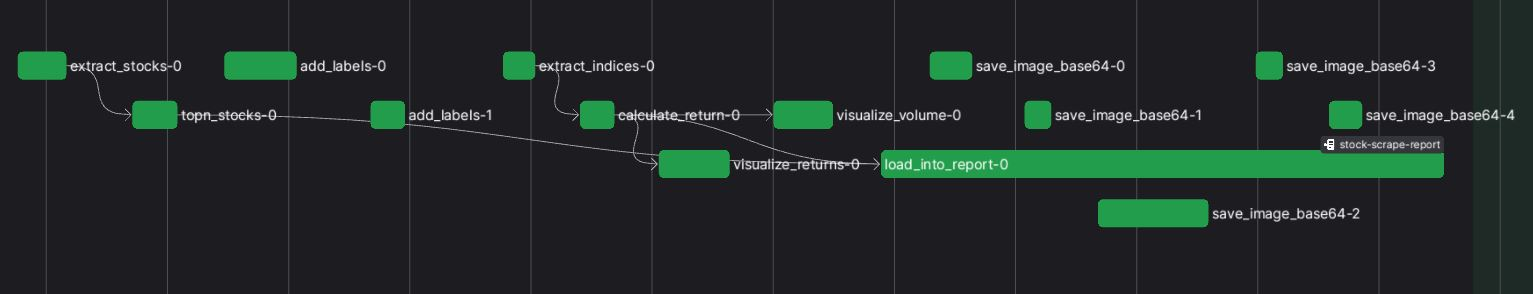

In [9]:
from IPython.display import Image

Image("Pipeline.JPG")

**The following report artifact was generated through our pipeline**:

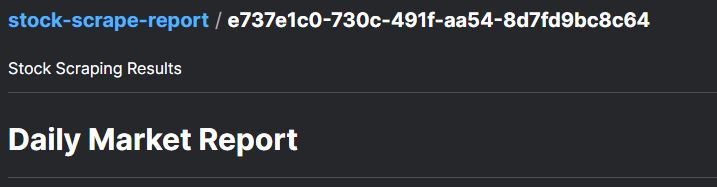

In [12]:
Image("Artifact_1.JPG")

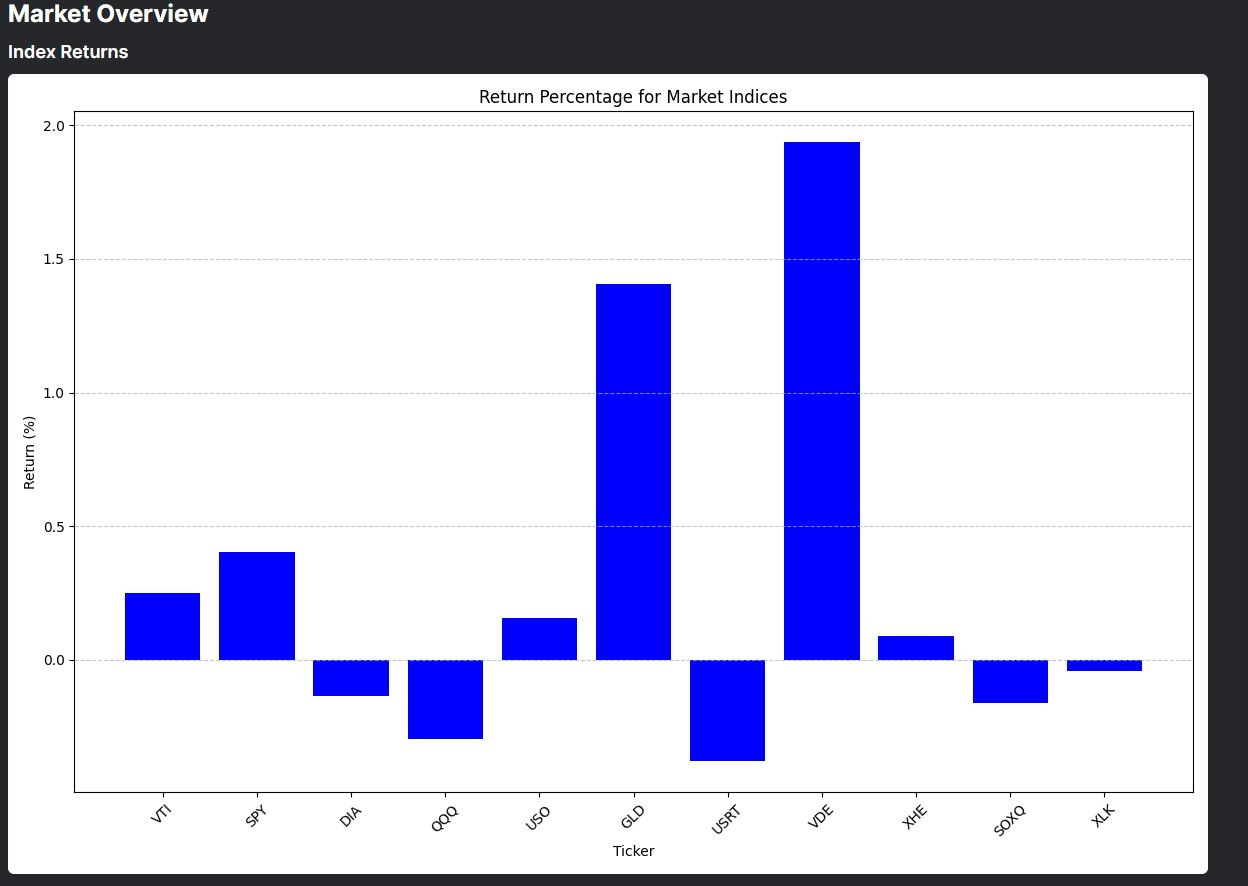

In [13]:
Image("Artifact_2.JPG")

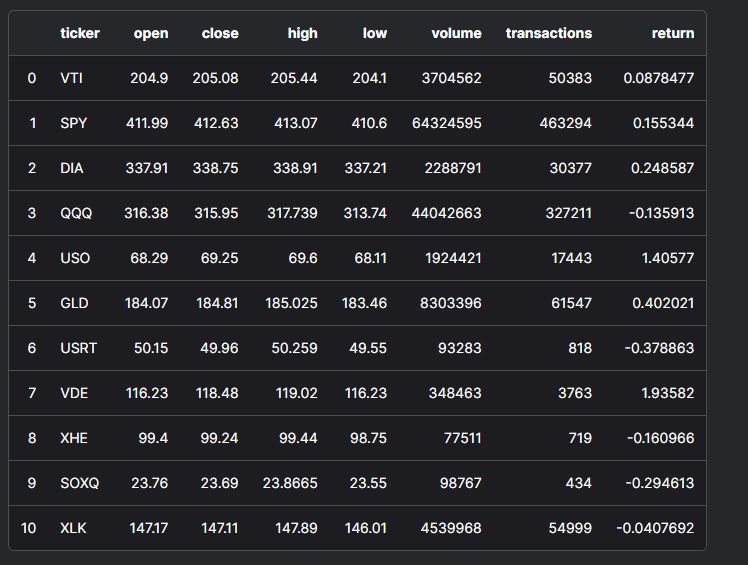

In [14]:
Image("Artifact_3.JPG")

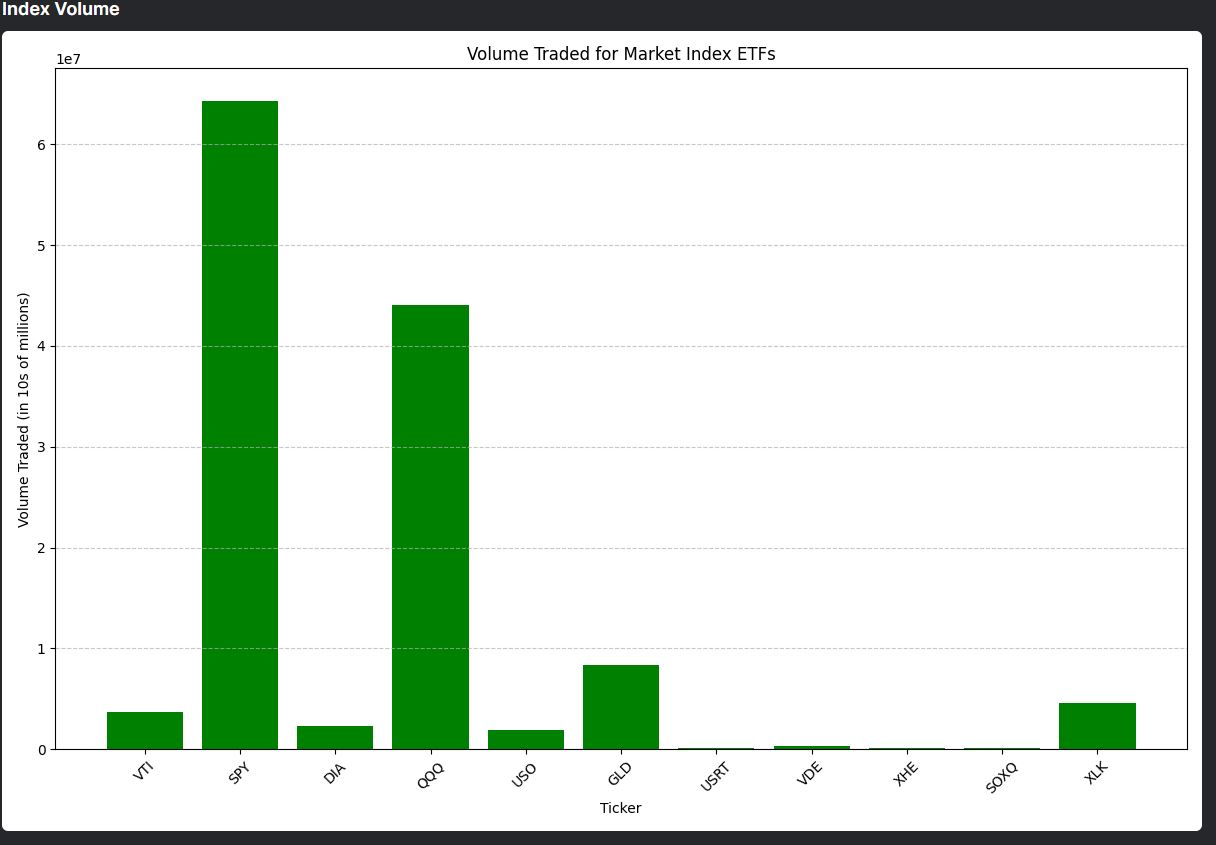

In [15]:
Image("Artifact_4.JPG")

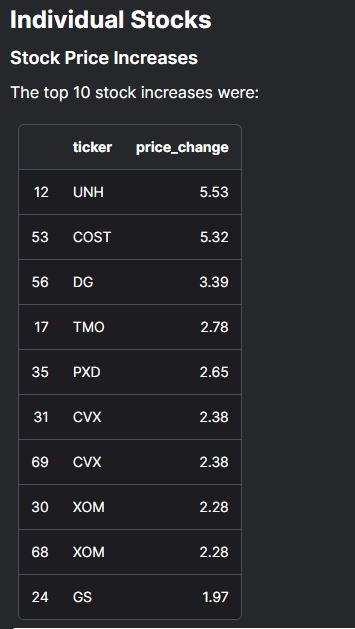

In [16]:
Image("Artifact_5.JPG")

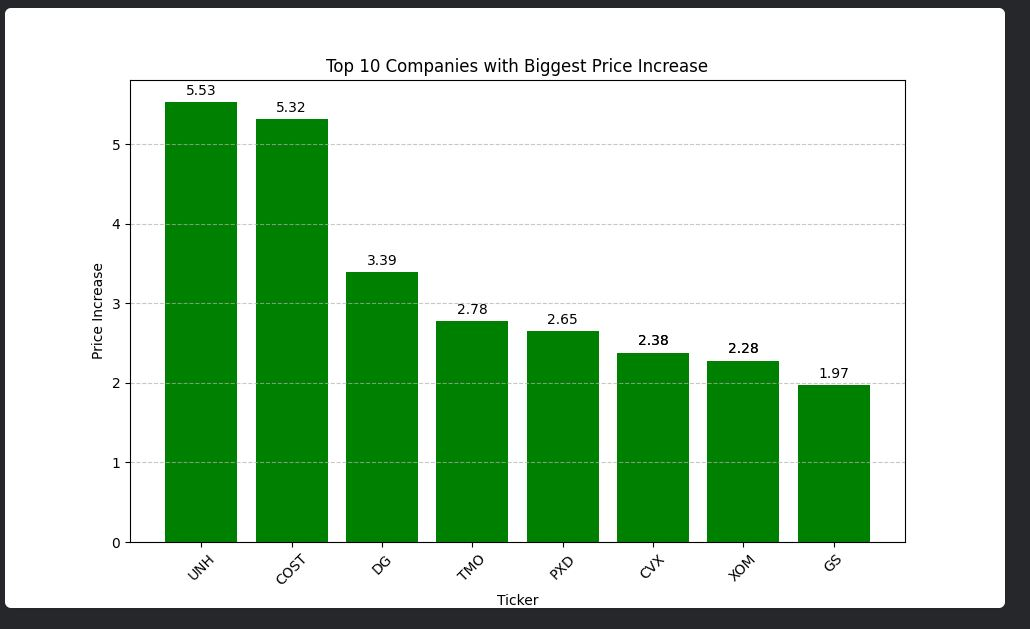

In [17]:
Image("Artifact_6.JPG")

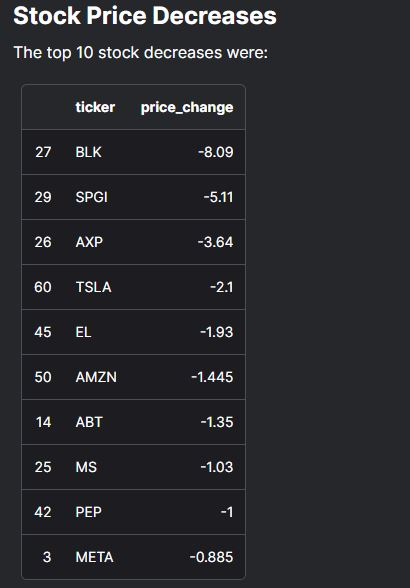

In [18]:
Image("Artifact_7.JPG")

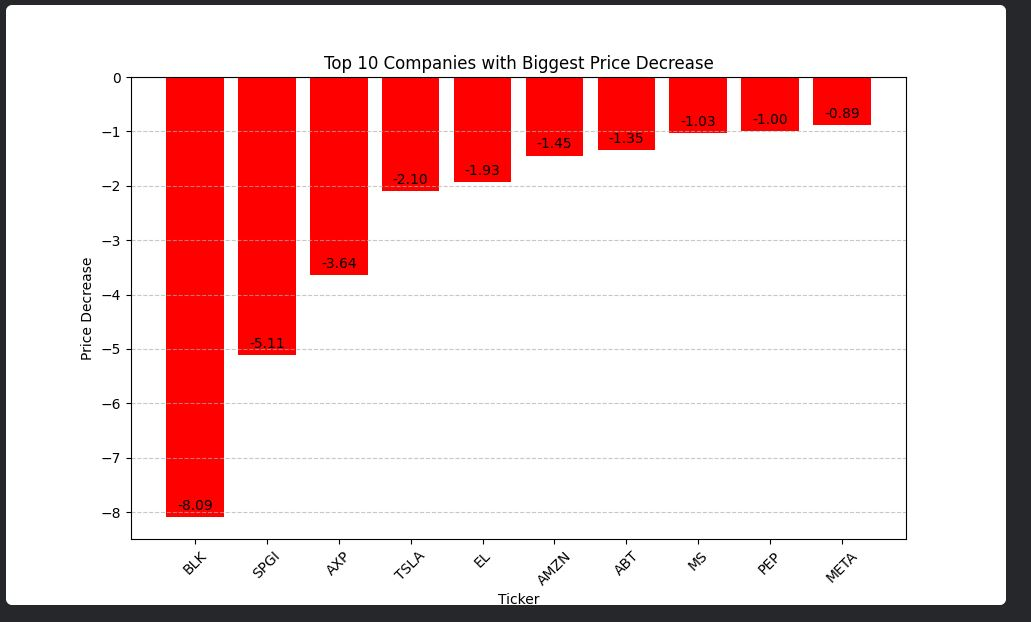

In [19]:
Image("Artifact_8.JPG")

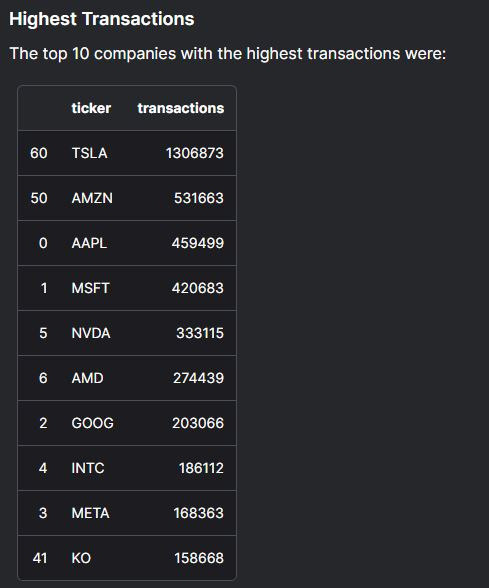

In [20]:
Image("Artifact_9.JPG")

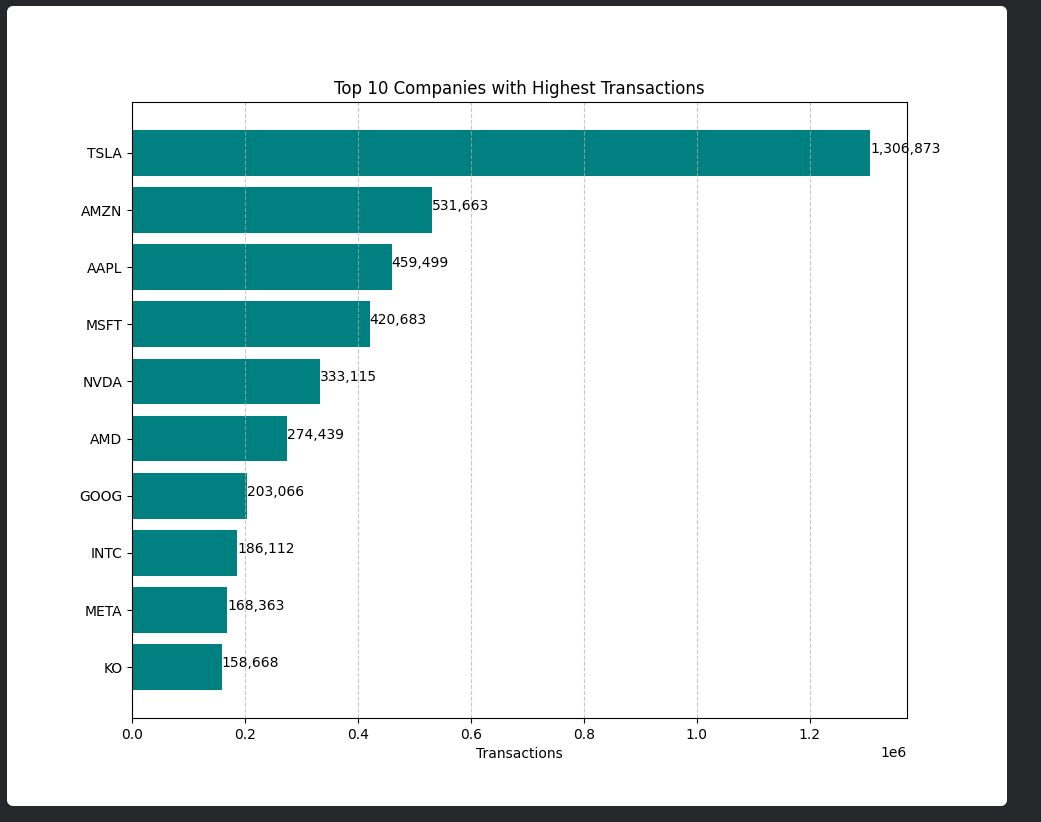

In [21]:
Image("Artifact_10.JPG")

## Final Remarks


In conclusion, the ETL pipelines designed for both stock and index data provide a robust framework for extracting, transforming, and loading financial data, enabling users to gain valuable insights for informed decision-making. By automating data retrieval, analysis, visualization, and report generation, these pipelines streamline the process and enhance efficiency in financial analysis.  

Looking ahead, a promising area for improvement involves integrating scheduling capabilities through Prefect to automate the execution of the ETL pipeline on a daily basis. Implementing a scheduled workflow would enable the pipeline to run autonomously, ensuring that the latest data is processed and analyzed regularly. Additionally, incorporating email functionality to distribute the artifact report to users would enhance accessibility and dissemination of insights, facilitating seamless decision-making processes. By automating these tasks, users can stay updated with timely reports and make informed decisions based on the latest financial data.  